## K-means

In [109]:
import time
import sys
! pip install numpy
import numpy as np
! pip install matplotlib
import matplotlib.pyplot as plt
import math
import os
from matplotlib.pyplot import imread
! pip install patchify
from patchify import patchify

from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.

import random
import cv2
import functools

np.random.seed(1)



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



These programming exercises will focus on K-means clustering. 

If you're unsure of how k-means works, read this very helpful and freely available online breakdown from Stanford's CS221 course; https://stanford.edu/~cpiech/cs221/handouts/kmeans.html


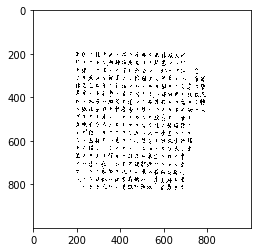

In [110]:
import os
from matplotlib.pyplot import imread
train_images = []
path = "../../Image_processing/result"
for file in os.listdir(path):
    if file.endswith(".png"):
        im = imread(path + "/" + file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        if(im.size == 3000000):  #abandon some blank imgs
            train_images.append(im)
plt.imshow(train_images[0])
plt.show()


Before splitting, the image size is (1000, 1000, 3)
After splitting, the patches are (64, 125, 125, 3)
A patch is like:


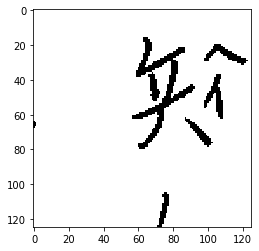

In [111]:

def patchify_images(image):
    a = 125
    return patchify(image, (a, a, 3), step=a).reshape((-1, a, a, 3))

patches = patchify_images(train_images[2])
print(f'Before splitting, the image size is {train_images[2].shape}')
print(f'After splitting, the patches are {patches.shape}')
print('A patch is like:')
plt.imshow(patches[5])
plt.show()
def compute_patch_feature(patch):
    #YOUR CODE HERE
    Red,Green,Blue = patch[:,:,0],patch[:,:,1],patch[:,:,2]
    meanRed = np.mean(Red)
    meanGreen = np.mean(Green)
    meanBlue = np.mean(Blue)
    return [meanRed,meanGreen,meanBlue]

train_points = []  #can't do futher work since xiang da li's work is incomplete, some of output img is blank.

for img in train_images:
    patches = patchify_images(img)
    for patch in patches:
        train_points.append(compute_patch_feature(patch))


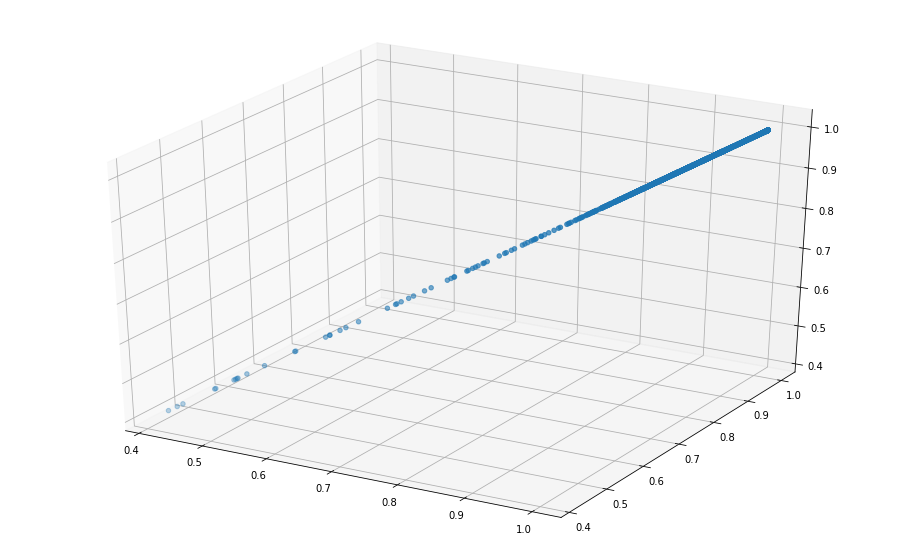

In [103]:
#X = np.load("./data.npy")
X = np.array(train_points)
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2])
plt.show()
 
k=2

K-means is a special, simple case of the Expectation Maximisation (EM) algorithm.

This simplified EM (k-means), is divided into two steps.

The **E-Step**, where for every sample in your dataset you find which "centroid" that datapoint is closest to that sample, and record that information.

The **M-Step**, where you move each "centroid" to the center of the samples which were found to be closest to it in the **E-Step**.

Each *centroid* is simply an estimated mean of a cluster. If you have $1$ centroid, then this centroid will become the mean of all your data.

Centroids are initially random values, and the k-means algorithm attempts to modify them so that each one represents the center of a cluster.

We have implemented a centroids initialization function.

In [104]:
def initialise_parameters(m, X):
    C = X[np.random.choice(X.shape[0], m)]
    return C

C = initialise_parameters(k, X)
print(C)

[[0.94816  0.94816  0.94816 ]
 [0.999488 0.999488 0.999488]]



---
   **1.1:** $E\_step(C, X) = L$, where $L$ is a matrix of the same dimension of the dataset $X$.
   
   This function is is the **E-Step** 

---

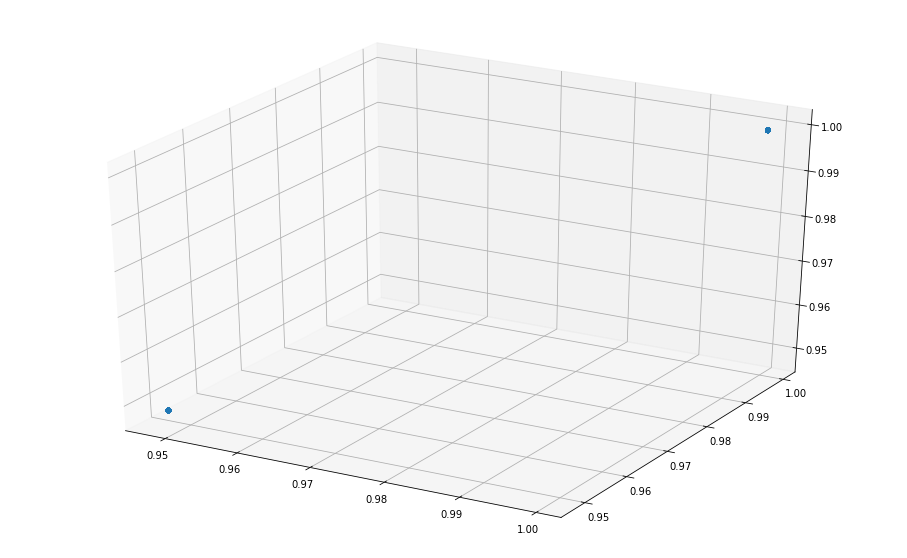

In [105]:
def distance(centre,sample):
    return(math.sqrt(np.sum((centre-sample)**2)))
#     return(math.sqrt((centre[0]-sample[0])**2+(centre[1]-sample[1])**2))
def E_step(C, X):
    m, n = X.shape
    L = np.zeros((m,n))
    # YOUR CODE HERE
    for i,sample in enumerate(X):
        mindist = 100000
        for c in C:
            dist = distance(c,sample)
            if(dist<mindist):
                mindist = dist
                L[i] = c
    return L
    
L = E_step(C, X)

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(L[:, 0], L[:, 1],L[:,2])
plt.show()

**TASK 1.2:** Create a function $M\_step(C, X, L) = C$ which returns $C$ modified so that each centroid in $C$ is placed in the middle of the samples assigned to it. This is the **M-Step**.

In other words, make each centroid in $C$ the average of all the samples which were found to be closest to it during the **E-step**. This is also called the "update step" for K-means.

---

**HINT:** https://docs.scipy.org/doc/numpy/reference/generated/numpy.array_equal.html

In [107]:
def M_step(C, X, L):
    # YOUR CODE HERE
    m, n = C.shape
    newC = np.zeros((m,n))
    for n,c in enumerate(C):
        arrsum = np.zeros((1,X.shape[1]))
        quantity = 0
        for i,j in enumerate(L):
            if(np.all(j == c)):
                arrsum = arrsum + X[i]
                quantity += 1
        if(quantity != 0):
            newC[n] = arrsum/quantity
        else:
            print("no")
    return newC


print('Before:')
print(C)
print('\nAfter:')
new_C = M_step(C, X, L)
print(new_C)

Before:
[[0.94816  0.94816  0.94816 ]
 [0.999488 0.999488 0.999488]]

After:
[[0.90826733 0.90826733 0.90826733]
 [0.99677553 0.99677553 0.99677553]]


Implement $kmeans(X, m, threshold) = C, L$ which takes a dataset $X$ (of any dimension) and a scalar value $m$ and a scalar $threshold$ as input. 


Final Parameters:
[[0.98036196 0.98036196 0.98036196]
 [0.88155411 0.88155411 0.88155411]]
(1684, 3)
(940, 3)


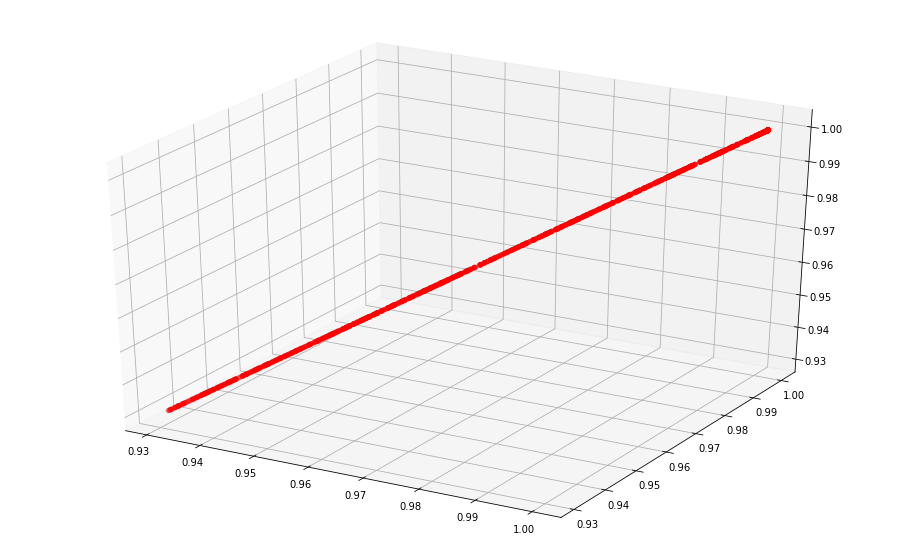

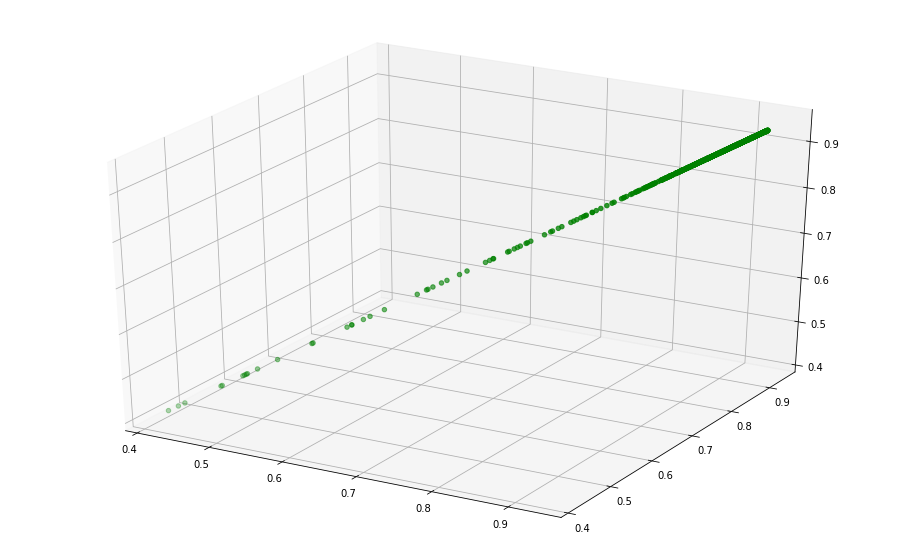

In [108]:
def kmeans(X, m, threshold):
    L = np.zeros(X.shape)
    C = initialise_parameters(m, X)
    diff = float('inf')
    loss_prev = float('inf')
    while diff > threshold:
        L = E_step(C, X)
        loss_cur = np.sum((np.linalg.norm(X - L, axis=1)**2))
        diff = abs(loss_prev - loss_cur)
        loss_prev = loss_cur
        C = M_step(C, X, L)
    # due to the fact that we pair the data point and cluster centroid
    # by the value in L match the value in C, we need to do E_step one more time
    L = E_step(C, X)
    return C, L

C_final, L_final = kmeans(X, k, 1e-6)

print('\nFinal Parameters:')
print(C_final)
def allocator(X, L, c):
    cluster = []
    for i in range(L.shape[0]):
        if np.array_equal(L[i, :], c):
            cluster.append(X[i, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b', 'y']
for i in range(k):
    cluster = allocator(X, L_final, C_final[i, :])
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')
    print(cluster.shape)
    ax.scatter(cluster[:, 0], cluster[:, 1],cluster[:,2],c=colours[i])
plt.show()